# 1. Import the required libraries

In [17]:
# Standard code libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)
from resurfemg.postprocessing import features as feat

config = Config()
%matplotlib widget

In [19]:
output_dir = os.path.join(config.get_directory('output_data'), 'software_paper')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.rcParams['svg.fonttype'] = 'none'


## 2. Load the ventilator and sEMG data

In [ ]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
base_path = config.get_directory('patient_data')
patient_paths = file_discovery.find_folders(
    base_path,
    folder_levels=['patient'])
patient = list(patient_paths['patient'].values)[0]

# Then find the files for the selected patients:
folder_levels = ['date', 'measurement']
patient_path = os.path.join(base_path, patient)

emg_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='EMG_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=patient_path,
    file_name_regex='Draeger_recording',
    extension_regex='poly5',
    folder_levels=folder_levels)

button_list = ipy_widgets.file_select(
    emg_files,
    folder_levels=folder_levels[:-1],
    default_value_select=[None, '006'],
    default_idx_select=[0, 6])

These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'EMG_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '001', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '002', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '003', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '004', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '005', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '006', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '007', 'EMG_recording.poly5'], ['No_NMC', '2021-12-31_10-31-03', '008', 'EMG_recording.poly5']]
These files did not match the provided depth:
 [['2021-12-27_09-16-26', '00_Incorrect', '006 - Vroegtijdig gestopt', 'Draeger_recording.poly5'], ['2021-12-27_09-16-26', '00_Incorrect', '009 - PS ipv PEEP', 'Draeger_recording.poly5'], ['No_NMC', '2021-12-

interactive(children=(Dropdown(description='date:', options=('2021-12-24_09-29-46', '2021-12-27_09-16-26', '20…

In [4]:
emg_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'EMG_recording.Poly5')
vent_file_chosen = os.path.join(
    patient_path, *[btn.value for btn in button_list], 'Draeger_recording.Poly5')

print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\EMG_recording.Poly5 
 P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\Draeger_recording.Poly5


In [5]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples[:, 1*fs_emg:61*fs_emg]
y_vent = data_vent_samples[:, 1*fs_vent:61*fs_vent]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

Reading file  P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\EMG_recording.Poly5
	 Number of samples:  762496 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  P:\TNW\CRPH\Projects\2021_Warnaar_TOPSPIN_studie\4_Patient_data\1_RAW\MST001\2021-12-24_09-29-46\006\Draeger_recording.Poly5
	 Number of samples:  37231 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [6]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw', 'F', 'Vvent'],
    units=['cmH2O', 'L/s', 'L'])


Auto-detected ECG channel from labels.
Auto-detected Pvent channel from labels.
Auto-detected Flow channel from labels.
Auto-detected Volume channel from labels.


In [7]:
x_lim = 8.0
y_lim = 10.0

In [8]:
vent_timeseries[0].baseline(
    signal_type='raw')

# Find tidal volume peaks
p_vent = vent_timeseries[vent_timeseries.p_vent_idx]
v_vent = vent_timeseries[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks(
    start_idx=0,
    end_idx=int(x_lim*fs_vent),
)
p_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=p_vent.y_baseline)
v_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=v_vent.y_baseline)

# 3a. Under-smoothed

In [9]:
emg_timeseries_under = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

emg_timeseries_under.run(
    'filter_emg',
    order=1,
    hp_cf=15,
    lp_cf=1000,
)
emg_timeseries_under.run(
    'gating',
    fill_method=3,
    gate_width_samples=(150 *  fs_emg) // 1000
)
emg_timeseries_under.run(
    'envelope',
    env_type='rms',
    env_window=(100 * fs_emg) // 1000,
    ci_alpha=0.05,
)
emg_timeseries_under.run(
    'baseline',
    percentile=20,
    window_s=int(7.5 * fs_emg)
)
emg_di_under = emg_timeseries_under.channels[1]
emg_di_under.detect_emg_breaths(
    peak_set_name='breaths',
    start_idx=0,
    end_idx = int(x_lim * fs_emg),
    min_peak_width_s=fs_emg//6,
    prominence_factor=0.5,
)
emg_di_under.peaks['breaths'].detect_on_offset(
    baseline=emg_di_under.y_baseline
)
t_pocc_peaks_vent = \
    p_vent.peaks['ventilator_breaths']['peak_idx'] / p_vent.param['fs']

emg_di_under.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_pocc_peaks_vent,
    linked_peak_set_name='linked_breaths',
)
emg_di_pocc_idxs = emg_di_under.peaks['breaths']['peak_idx']
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di_under.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di_under.y_baseline,
)
emg_di_under.peaks['breaths'].peak_df['amplitude'] = sEAdi_amplitudes

emg_di_under.peaks['breaths'].peak_df, emg_di_under.peaks['linked_breaths'].peak_df
# emg_di_under.peaks['breaths'].peak_df

Auto-detected ECG channel from labels.
Set ECG channel used for ECG removal.


(   peak_idx  start_idx  end_idx  valid  amplitude
 0      2555       1737     3906   True   5.297286
 1      7414       6789     8925   True   4.703112
 2     12566      11546    13501   True   4.403128,
    peak_idx  start_idx  end_idx  valid
 0      2555       1737     3906   True
 1      7414       6789     8925   True
 2     12566      11546    13501   True)

In [10]:
emg_timeseries_good = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

emg_timeseries_good.run(
    'filter_emg',
    order=3,
    hp_cf=20,
    lp_cf=500,

)
emg_timeseries_good.run(
    'gating',
    fill_method=3,
    gate_width_samples=(200 *  fs_emg) // 1000
)
emg_timeseries_good.run(
    'envelope',
    env_type='rms',
    env_window=(250 * fs_emg) // 1000,
    ci_alpha=0.05,
)
emg_timeseries_good.run(
    'baseline',
    percentile=33,
    window_s=int(7.5 * fs_emg)
)
emg_di_good = emg_timeseries_good[1]
emg_di_good.detect_emg_breaths(
    peak_set_name='breaths',
    start_idx=0,
    end_idx = int(x_lim * fs_emg),
    min_peak_width_s=fs_emg//4,
    prominence_factor=1.0,
)
emg_di_good.peaks['breaths'].detect_on_offset(
    baseline=emg_di_good.y_baseline
)
t_pocc_peaks_vent = \
    p_vent.peaks['ventilator_breaths']['peak_idx'] / p_vent.param['fs']

emg_di_good.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_pocc_peaks_vent,
    linked_peak_set_name='linked_breaths',
)

emg_di_pocc_idxs = emg_di_good.peaks['breaths']['peak_idx']
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di_good.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di_good.y_baseline,
)
emg_di_good.peaks['breaths'].peak_df['amplitude'] = sEAdi_amplitudes
print(emg_di_good.peaks['breaths'], '\n', emg_di_good.peaks['linked_breaths'])
# emg_di_under.peaks['breaths'].peak_df

Auto-detected ECG channel from labels.
Set ECG channel used for ECG removal.
   peak_idx  start_idx  end_idx  valid  amplitude
0      2620       1476     3704   True   4.646369
1      7842       6293     8720   True   4.346581
2     12547      11452    13621   True   4.063225 
    peak_idx  start_idx  end_idx  valid
0      2620       1476     3704   True
1      7842       6293     8720   True
2     12547      11452    13621   True


In [11]:
emg_timeseries_over = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi', 'EMGpara'],
    units=3*['uV'])

emg_timeseries_over.run(
    'filter_emg',
    order=3,
    hp_cf=30,
    lp_cf=500,
)
emg_timeseries_over.run(
    'gating',
    fill_method=3,
    gate_width_samples=(300 *  fs_emg) // 1000,
)
emg_timeseries_over.run(
    'envelope',
    env_type='rms',
    env_window=(500 * fs_emg) // 1000,
    ci_alpha=0.05,
)
emg_timeseries_over.run(
    'baseline',
    percentile=33,
    window_s=int(7.5 * fs_emg)
)
emg_di_over = emg_timeseries_over[1]
emg_di_over.detect_emg_breaths(
    peak_set_name='breaths',
    start_idx=0,
    end_idx = int(x_lim * fs_emg),
    min_peak_width_s=fs_emg//4,
    prominence_factor=1.0,
)
emg_di_over.peaks['breaths'].detect_on_offset(
    baseline=emg_di_over.y_baseline
)
t_pocc_peaks_vent = \
    p_vent.peaks['ventilator_breaths']['peak_idx'] / p_vent.param['fs']

emg_di_pocc_idxs = emg_di_over.peaks['breaths']['peak_idx']
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di_over.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di_over.y_baseline,
)
emg_di_over.peaks['breaths'].peak_df['amplitude'] = sEAdi_amplitudes

emg_di_over.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_pocc_peaks_vent,
    linked_peak_set_name='linked_breaths',
)
print(emg_di_over.peaks['breaths'], '\n', emg_di_over.peaks['linked_breaths'])
# emg_di_under.peaks['breaths'].peak_df

Auto-detected ECG channel from labels.
Set ECG channel used for ECG removal.
   peak_idx  start_idx  end_idx  valid  amplitude
0      2668       1194     4024   True   1.988114
1      7613       6098     8950   True   1.878556
2     12277      11253    14000   True   1.715243 
    peak_idx  start_idx  end_idx  valid  amplitude
0      2668       1194     4024   True   1.988114
1      7613       6098     8950   True   1.878556
2     12277      11253    14000   True   1.715243


(0.0, 10.0)

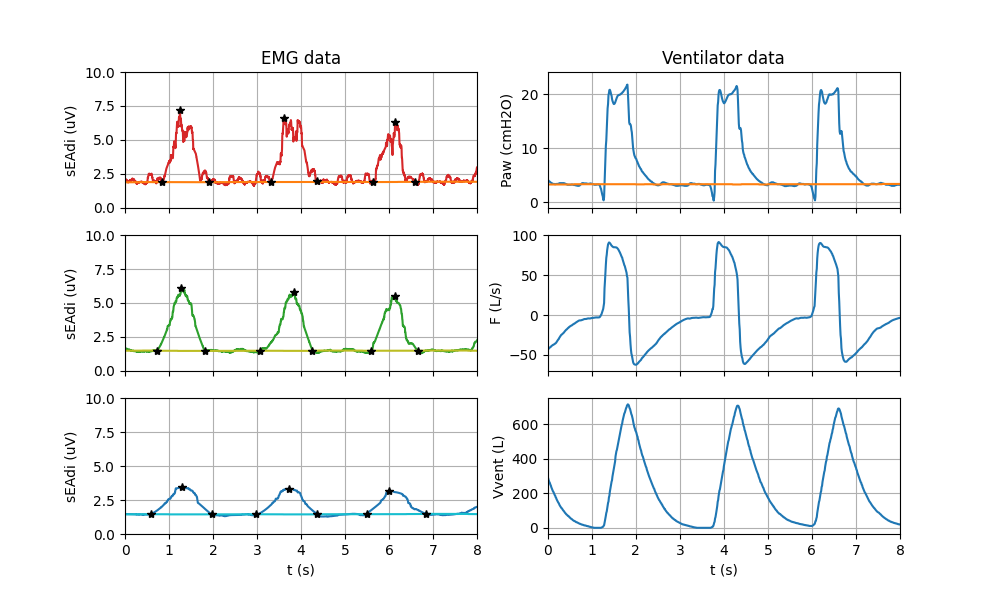

In [12]:
# Plot the identified Pocc peaks in p_vent and sEAdi
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries_under[1].plot_full(axes_emg[0], signal_type='env', colors=['tab:red', 'tab:orange'])
emg_di_under.plot_markers(peak_set_name='breaths', axes=axes_emg[0], colors=['k', 'k', 'k'])
axes_emg[0].set_ylabel('sEAdi (uV)')
axes_emg[0].set_ylim([0, y_lim])

emg_timeseries_good[1].plot_full(axes_emg[1], signal_type='env', colors=['tab:green', 'tab:olive'])
emg_di_good.plot_markers(peak_set_name='breaths', axes=axes_emg[1], colors=['k', 'k', 'k'])
axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[1].set_ylim([0, y_lim])

emg_timeseries_over[1].plot_full(axes_emg[2], signal_type='env', colors=['tab:blue', 'tab:cyan'])
emg_di_over.plot_markers(peak_set_name='breaths', axes=axes_emg[2], colors=['k', 'k', 'k'])
axes_emg[2].set_ylabel('sEAdi (uV)')
axes_emg[2].set_ylim([0, y_lim])

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([0, x_lim])
axes_emg[1].set_ylim([0, y_lim])

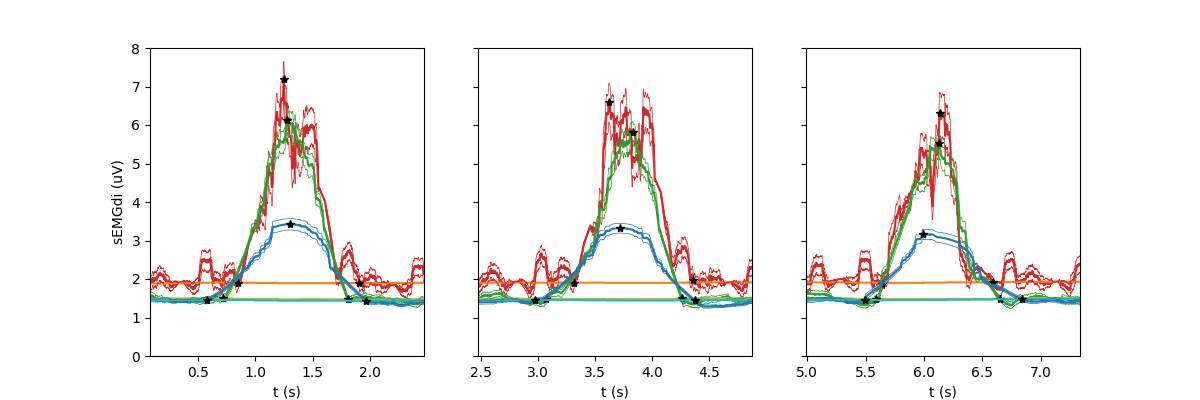

In [38]:
# Plot the individual peaks
n_peaks = len(emg_di_under.peaks['breaths'])
fig, axis = plt.subplots(nrows=1, ncols=n_peaks, figsize=(12, 4), sharex='col', sharey='row')

import numpy as np

sub_x_lim_start = (np.min([emg_di_under.peaks['breaths']['start_idx'],
                           emg_di_good.peaks['breaths']['start_idx'],
                           emg_di_over.peaks['breaths']['start_idx']], axis=0) - fs_emg/2) / fs_emg
sub_x_lim_end = (np.max([emg_di_under.peaks['breaths']['end_idx'],
                         emg_di_good.peaks['breaths']['end_idx'],
                         emg_di_over.peaks['breaths']['end_idx']], axis=0) + fs_emg/2) / fs_emg
sub_x_lim_start, sub_x_lim_end

# axes_emg = axis[0, :]
axes_emg = axis
emg_di_under.plot_peaks(
    axes=axes_emg,
    peak_set_name='breaths', 
    margin_s=fs_emg,
    colors=['tab:red', 'tab:orange'],
    plot_ci=False)
for idx in range(len(emg_di_under.peaks['breaths'])):
    start_idx, end_idx = np.max(
        [[emg_di_under.peaks['breaths'][key][idx] for key in ['start_idx', 'end_idx']] + np.array([-fs_emg, fs_emg]), [0, 0]], axis=0)
    axes_emg[idx].plot(emg_di_under.t_data[start_idx:end_idx], np.transpose(np.array(emg_di_under.y_env_ci)[:, start_idx:end_idx]), color='tab:red', linewidth=0.5)
emg_di_under.plot_markers(axes=axes_emg, peak_set_name='breaths', colors=['k', 'k', 'k'])
emg_di_good.plot_peaks(
    axes=axes_emg,
    peak_set_name='breaths', 
    margin_s=fs_emg,
    colors=['tab:green', 'tab:olive'],
    plot_ci=False)
for idx in range(len(emg_di_under.peaks['breaths'])):
    start_idx, end_idx = np.max(
        [[emg_di_good.peaks['breaths'][key][idx] for key in ['start_idx', 'end_idx']] + np.array([-fs_emg, fs_emg]), [0, 0]], axis=0)
    axes_emg[idx].plot(emg_di_good.t_data[start_idx:end_idx], np.transpose(np.array(emg_di_good.y_env_ci)[:, start_idx:end_idx]), color='tab:green', linewidth=0.5)
emg_di_good.plot_markers(axes=axes_emg, peak_set_name='breaths', colors=['k', 'k', 'k'])
emg_di_over.plot_peaks(
    axes=axes_emg,
    peak_set_name='breaths', 
    margin_s=fs_emg,
    colors=['tab:blue', 'tab:cyan'],
    plot_ci=False)
for idx in range(len(emg_di_under.peaks['breaths'])):
    start_idx, end_idx = np.max(
        [[emg_di_over.peaks['breaths'][key][idx] for key in ['start_idx', 'end_idx']] + np.array([-fs_emg, fs_emg]), [0, 0]], axis=0)
    axes_emg[idx].plot(emg_di_over.t_data[start_idx:end_idx], np.transpose(np.array(emg_di_over.y_env_ci)[:, start_idx:end_idx]), color='tab:blue', linewidth=0.5)
emg_di_over.plot_markers(axes=axes_emg, peak_set_name='breaths', colors=['k', 'k', 'k'])
axes_emg[0].set_ylabel('sEMGdi (uV)')
# axes_emg[0].set_ylim([0, y_lim])
axes_emg[0].set_ylim([0, 8.0])
for i, ax in enumerate(axes_emg):
    ax.set_xlim([sub_x_lim_start[i], sub_x_lim_end[i]])
    ax.set_xlabel('t (s)')
    ax.grid(False)

# axes_vent = axis[1, :]
# p_vent.plot_peaks(axes=axes_vent, margin_s=int(fs_vent//(2/3)),
#                   peak_set_name='ventilator_breaths')
# p_vent.plot_markers(axes=axes_vent, peak_set_name='ventilator_breaths')

# for axis in axes_vent:
#     axis.set_xlabel('t (s)')

In [39]:
fig_path = os.path.join(output_dir, 'three_pipelines.svg')
fig.savefig(fig_path, format='svg', bbox_inches='tight')

In [40]:
# Calculate ETPdi & Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
# Under-filtered pipeline
emg_di_under.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')
emg_di_under.calculate_time_products(
    peak_set_name='breaths', include_aub=False, parameter_name='ETPdi-aub')
emg_di_under.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


# Good pipeline
emg_di_good.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')
emg_di_good.calculate_time_products(
    peak_set_name='breaths', include_aub=False, parameter_name='ETPdi-aub')
emg_di_good.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)



# Over-filtered pipeline
emg_di_over.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')
emg_di_over.calculate_time_products(
    peak_set_name='breaths', include_aub=False, parameter_name='ETPdi-aub')
emg_di_over.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)



In [46]:
emg_di_under.peaks['breaths'].peak_df[['peak_idx', 'start_idx', 'end_idx', 'amplitude', 'ETPdi']]
# emg_di_good.peaks['breaths'].peak_df[['peak_idx', 'start_idx', 'end_idx', 'amplitude', 'ETPdi']]
# emg_di_over.peaks['breaths'].peak_df[['peak_idx', 'start_idx', 'end_idx', 'amplitude', 'ETPdi']]

,peak_idx,start_idx,end_idx,amplitude,ETPdi
0,2555,1737,3906,5.297286,2.618412
1,7414,6789,8925,4.703112,2.740878
2,12566,11546,13501,4.403128,1.997393


In [49]:
emg_di_under.peaks['breaths'].quality_values_df[['peak_idx', 'snr', 'aub', 'bell']]
# print(emg_di_under.peaks['breaths'].quality_outcomes_df)
# print('')
# emg_di_good.peaks['breaths'].quality_values_df[['peak_idx', 'snr', 'aub', 'bell']]
# # print(emg_di_good.peaks['breaths'].quality_outcomes_df)
# # print('')
# emg_di_over.peaks['breaths'].quality_values_df[['peak_idx', 'snr', 'aub', 'bell']]
# print(emg_di_over.peaks['breaths'].quality_outcomes_df)
# print('')

,peak_idx,snr,aub,bell
0,2555,3.798777,10.868412,15.278023
1,7414,3.466248,10.534968,16.791805
2,12566,3.298465,13.420541,20.191748


In [44]:
print(emg_di_under.peaks['breaths'].quality_outcomes_df)
print('')
print(emg_di_good.peaks['breaths'].quality_outcomes_df)
print('')
print(emg_di_over.peaks['breaths'].quality_outcomes_df)
print('')

   peak_idx  baseline_detection  interpeak_distance   snr   aub  bell  \
0      2555                True                True  True  True  True   
1      7414                True                True  True  True  True   
2     12566                True                True  True  True  True   

   relative_aub  relative_etp  
0          True          True  
1          True          True  
2          True          True  

   peak_idx  baseline_detection  interpeak_distance   snr   aub  bell  \
0      2620                True                True  True  True  True   
1      7842                True                True  True  True  True   
2     12547                True                True  True  True  True   

   relative_aub  relative_etp  
0          True          True  
1          True          True  
2          True          True  

   peak_idx  baseline_detection  interpeak_distance   snr   aub  bell  \
0      2668                True                True  True  True  True   
1      761